In [198]:
# 模型训练
import numpy as np
import pandas as pd
import os
import tqdm
import datetime
import time

base_path = 'stock'

market_map = {'主板':0, '科创板':1, '中小板':2}
exchange_map = {'SZSE':0, 'SSE':1}
is_hs_map = {'S':0, 'N':1, 'H':2}

area_map = {'深圳': 0, '北京': 1, '吉林': 2, '江苏': 3, '辽宁': 4, '广东': 5, '安徽': 6, '四川': 7, '浙江': 8,
            '湖南': 9, '河北': 10, '新疆': 11, '山东': 12, '河南': 13, '山西': 14, '江西': 15, '青海': 16, 
            '湖北': 17, '内蒙': 18, '海南': 19, '重庆': 20, '陕西': 21, '福建': 22, '广西': 23, '天津': 24, 
            '云南': 25, '贵州': 26, '甘肃': 27, '宁夏': 28, '黑龙江': 29, '上海': 30, '西藏': 31}

industry_map = {'银行': 0, '全国地产': 1, '生物制药': 2, '环境保护': 3, '区域地产': 4, '酒店餐饮': 5, '运输设备': 6, 
 '综合类': 7, '建筑工程': 8, '玻璃': 9, '家用电器': 10, '文教休闲': 11, '其他商业': 12, '元器件': 13, 
 'IT设备': 14, '其他建材': 15, '汽车服务': 16, '火力发电': 17, '医药商业': 18, '汽车配件': 19, '广告包装': 20, 
 '轻工机械': 21, '新型电力': 22, '饲料': 23, '电气设备': 24, '房产服务': 25, '石油加工': 26, '铅锌': 27, '农业综合': 28,
 '批发业': 29, '通信设备': 30, '旅游景点': 31, '港口': 32, '机场': 33, '石油贸易': 34, '空运': 35, '医疗保健': 36,
 '商贸代理': 37, '化学制药': 38, '影视音像': 39, '工程机械': 40, '软件服务': 41, '证券': 42, '化纤': 43, '水泥': 44, 
 '专用机械': 45, '供气供热': 46, '农药化肥': 47, '机床制造': 48, '多元金融': 49, '百货': 50, '中成药': 51, '路桥': 52, 
 '造纸': 53, '食品': 54, '黄金': 55, '化工原料': 56, '矿物制品': 57, '水运': 58, '日用化工': 59, '机械基件': 60, 
 '汽车整车': 61, '煤炭开采': 62, '铁路': 63, '染料涂料': 64, '白酒': 65, '林业': 66, '水务': 67, '水力发电': 68, 
 '互联网': 69, '旅游服务': 70, '纺织': 71, '铝': 72, '保险': 73, '园区开发': 74, '小金属': 75, '铜': 76, '普钢': 77, 
 '航空': 78, '特种钢': 79, '种植业': 80, '出版业': 81, '焦炭加工': 82, '啤酒': 83, '公路': 84, '超市连锁': 85, 
 '钢加工': 86, '渔业': 87, '农用机械': 88, '软饮料': 89, '化工机械': 90, '塑料': 91, '红黄酒': 92, '橡胶': 93, '家居用品': 94,
 '摩托车': 95, '电器仪表': 96, '服饰': 97, '仓储物流': 98, '纺织机械': 99, '电器连锁': 100, '装修装饰': 101, '半导体': 102, 
 '电信运营': 103, '石油开采': 104, '乳制品': 105, '商品城': 106, '公共交通': 107, '船舶': 108, '陶瓷': 109}

In [199]:
def JudgeST(x):
    if 'ST' in x:
        return 1
    else:
        return 0

def GetMA(df, col_name, rolling_day):
    tmp_array = df[col_name].values.reshape(-1)
    df.loc[ rolling_day:, col_name + '_'+str(rolling_day)] = (tmp_array[0:-rolling_day] - 
                                                              tmp_array[rolling_day:]) / tmp_array[0:-rolling_day]
    return df

col = ['ma'+str(i) for i in [5, 10, 15, 20, 30]] + ['ma_v_'+str(i) for i in [5, 10, 15, 20, 30]]

company_info = pd.read_csv(os.path.join(base_path, 'company_info.csv'))
company_info['is_ST'] = company_info['name'].apply(JudgeST)
# 丢弃一些多余的信息
company_info.drop(['symbol', 'fullname'], axis=1, inplace=True)
company_info.dropna(inplace=True)
company_info['market'] = company_info['market'].map(market_map)
company_info['exchange'] = company_info['exchange'].map(exchange_map)
company_info['is_hs'] = company_info['is_hs'].map(is_hs_map)


# 读取指数信息
stock_index_info = pd.DataFrame()
tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH_NormalData.csv'))
tmp_list = list(tmp_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))

# 读取股票交易信息
stock_info = pd.DataFrame()
remove_stock = []
tmp_list = []
for ts_code in tqdm.tqdm(company_info['ts_code']):
    try:
        tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', ts_code + '_NormalData.csv'))
    except:
        continue
        pass
    # 还需要去除一些停牌时间很久的企业，后期加
    if len(tmp_df) < 100:  # 去除一些上市不久的企业
        remove_stock.append(ts_code)
        continue
    tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index(drop=True)    
    for tmp_col in col:
        for rolling_day in [5]:
            tmp_df = GetMA(tmp_df, tmp_col, rolling_day)
    tmp_list.append(tmp_df)
    
stock_info = pd.concat(tmp_list)
stock_info = stock_info.reset_index(drop=True)
ts_code_map = dict(zip(list(company_info['ts_code']), range(len(company_info))))


stock_info = stock_info.reset_index(drop=True)
stock_info['ts_code_id'] = stock_info['ts_code'].map(ts_code_map)

stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
stock_info['ts_date_id'] = (10000 + stock_info['ts_code_id']) * 10000 + stock_info['trade_date_id']
stock_info = stock_info.merge(company_info, how='left', on='ts_code')
stock_info_copy = stock_info.copy()

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:03<00:00, 49.01it/s]


In [200]:
stock_info = stock_info.drop_duplicates(subset=['ts_date_id'])
print(len(stock_info), len(stock_info_copy))

138535 138535


# 特征工程

In [201]:
feature_col = []

In [202]:
# 获取月份 和 星期几
def get_weekday(x):
    x = str(x)
    return datetime.datetime.fromtimestamp(time.mktime(time.strptime(x, "%Y%m%d"))).weekday()
stock_info['month'] = stock_info['trade_date'].apply(lambda x: int(str(x)[4:6]))
stock_info['weekday'] = stock_info['trade_date'].apply(get_weekday)
feature_col.append('month')
feature_col.append('weekday')

In [203]:
# 添加涨跌停信息
limit_info = pd.read_csv('limit.csv')
limit_info.drop('file', axis=1, inplace=True)
limit_info['U-D'] = limit_info['U'] - limit_info['D']
limit_info = limit_info.rename(columns={'date':'trade_date'})
stock_info = stock_info.merge(limit_info[['U-D', 'trade_date']], on='trade_date', how='left')
feature_col.append('U-D')

In [204]:
# 求相对的vol 这里与10均线比较
stock_info['vol'] = (stock_info['vol'] - stock_info['ma_v_10']) / stock_info['ma_v_10']
feature_col.append('vol')

#转换low colse等
col = ['open', 'high', 'low', 'close', 'pre_close']
for tmp_col in col:
    stock_info[tmp_col+'_transform'] = (stock_info[tmp_col] - stock_info['ma10']) / stock_info['ma10']
    feature_col.append(tmp_col+'_transform')


In [205]:
# 添加大盘指数信息
tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
for tmp_col in ['amount', 'pre_close']:
    tmp_df = tmp_df.rename(columns={tmp_col: tmp_col + '_index_000001'})
    stock_info = stock_info.merge(tmp_df[['trade_date', tmp_col + '_index_000001']], on='trade_date', how='left')

for tmp_col in ['amount_index_000001', 'pre_close_index_000001', 'amount', 'pre_close']:
    print(tmp_col)
    for i in range(5):
        tmp_df = stock_info[['ts_date_id', tmp_col]]
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        tmp_df = tmp_df.rename(columns={tmp_col:new_col_name})
        feature_col.append(new_col_name)
        tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1
        stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')
    for i in range(5):
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        stock_info[new_col_name] = (stock_info[tmp_col] - stock_info[new_col_name]) / stock_info[new_col_name]

amount_index_000001
pre_close_index_000001
amount
pre_close


In [206]:
feature_col.append('turnover_rate')

In [207]:
stock_info.columns

Index(['trade_date', 'ts_code', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount', 'turnover_rate', 'volume_ratio',
       'ma5', 'ma_v_5', 'ma10', 'ma_v_10', 'ma15', 'ma_v_15', 'ma20',
       'ma_v_20', 'ma30', 'ma_v_30', 'ma5_5', 'ma10_5', 'ma15_5', 'ma20_5',
       'ma30_5', 'ma_v_5_5', 'ma_v_10_5', 'ma_v_15_5', 'ma_v_20_5',
       'ma_v_30_5', 'ts_code_id', 'trade_date_id', 'ts_date_id', 'name',
       'area', 'industry', 'market', 'exchange', 'list_date', 'is_hs', 'is_ST',
       'month', 'weekday', 'U-D', 'open_transform', 'high_transform',
       'low_transform', 'close_transform', 'pre_close_transform',
       'amount_index_000001', 'pre_close_index_000001',
       'amount_index_000001_shift_1', 'amount_index_000001_shift_2',
       'amount_index_000001_shift_3', 'amount_index_000001_shift_4',
       'amount_index_000001_shift_5', 'pre_close_index_000001_shift_1',
       'pre_close_index_000001_shift_2', 'pre_close_index_000001_shift_3',
 

特征需要向前移一天，策略买入是第二天的开盘价，所以当天算出来的特征需要向前平移一天

将特征向前平移一天也可以方便后期给大家推荐股票

设置买入时间为第二天的开盘，买入价格开盘价


In [208]:
stock_info['ts_date_id'] = stock_info['ts_date_id'] + 1

In [209]:
stock_info.head()

,trade_date,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,...,amount_shift_1,amount_shift_2,amount_shift_3,amount_shift_4,amount_shift_5,pre_close_shift_1,pre_close_shift_2,pre_close_shift_3,pre_close_shift_4,pre_close_shift_5
0,20200102,000004.SZ,22.65,22.90,22.17,22.33,22.59,-0.26,-1.1510,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200103,000004.SZ,22.31,22.48,22.03,22.35,22.33,0.02,0.0896,NaN,...,-0.258206,NaN,NaN,NaN,NaN,-0.011510,NaN,NaN,NaN,NaN
2,20200106,000004.SZ,22.20,22.20,21.55,21.75,22.35,-0.60,-2.6846,NaN,...,0.487773,0.103622,NaN,NaN,NaN,0.000896,-0.010624,NaN,NaN,NaN
3,20200107,000004.SZ,21.80,22.20,21.67,22.10,21.75,0.35,1.6092,NaN,...,-0.135541,0.286119,-0.045964,NaN,NaN,-0.026846,-0.025974,-0.037185,NaN,NaN
4,20200108,000004.SZ,21.91,22.77,21.78,21.78,22.10,-0.32,-1.4480,NaN,...,-0.097277,-0.219633,0.161009,-0.13877,NaN,0.016092,-0.011186,-0.010300,-0.021691,NaN


In [210]:
stock_info.ts_date_id.head()

0    100000001
1    100000002
2    100000003
3    100000004
4    100000005
Name: ts_date_id, dtype: int64

In [211]:
stock_info.tail()

,trade_date,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,...,amount_shift_1,amount_shift_2,amount_shift_3,amount_shift_4,amount_shift_5,pre_close_shift_1,pre_close_shift_2,pre_close_shift_3,pre_close_shift_4,pre_close_shift_5
138530,20231114,605398.SH,33.78,34.03,33.42,33.90,33.79,0.11,0.3255,-0.403686,...,-0.496155,-0.055423,-0.328796,-0.459290,-0.435701,0.039692,0.009259,-0.006176,-0.016016,-0.022563
138531,20231115,605398.SH,34.24,34.83,33.85,34.59,33.90,0.69,2.0354,0.176451,...,1.088638,0.052350,0.972879,0.401903,0.129348,0.003255,0.043077,0.012545,-0.002941,-0.012813
138532,20231116,605398.SH,34.36,35.30,34.28,34.39,34.59,-0.20,-0.5782,0.072003,...,-0.094158,0.891976,-0.046737,0.787116,0.269902,0.020354,0.023676,0.064308,0.033154,0.017353
138533,20231117,605398.SH,34.39,34.84,34.01,34.84,34.39,0.45,1.3085,-0.166548,...,-0.235917,-0.307862,0.445626,-0.271628,0.365505,-0.005782,0.014454,0.017757,0.058154,0.027180
138534,20231120,605398.SH,34.85,34.88,34.09,34.23,34.84,-0.61,-1.7509,-0.190973,...,-0.104732,-0.315941,-0.380351,0.294224,-0.347912,0.013085,0.007228,0.027729,0.031074,0.072000


In [212]:
stock_info.ts_date_id.tail()

138530    101500937
138531    101500938
138532    101500939
138533    101500940
138534    101500941
Name: ts_date_id, dtype: int64

# 标签读取

In [213]:
label_path = os.path.join('stock','label', 'label.csv')
label = pd.read_csv(label_path)
label = label[['ts_code', 'trade_date', 'open', 'ts_date_id', 'label_final']]

In [214]:
label.head()

,ts_code,trade_date,open,ts_date_id,label_final
0,000004.SZ,20200102,22.65,100000000,0
1,000004.SZ,20200103,22.31,100000001,0
2,000004.SZ,20200106,22.20,100000002,0
3,000004.SZ,20200107,21.80,100000003,0
4,000004.SZ,20200108,21.91,100000004,0


In [215]:
label.tail()

,ts_code,trade_date,open,ts_date_id,label_final
134200,605398.SH,20231017,34.00,101500916,0
134201,605398.SH,20231018,34.04,101500917,0
134202,605398.SH,20231019,35.26,101500918,0
134203,605398.SH,20231020,30.15,101500919,1
134204,605398.SH,20231023,31.21,101500920,1


In [216]:
stock_info.drop(['open', 'trade_date', 'ts_code'], axis=1, inplace=True)
stock_info = label.merge(stock_info, on='ts_date_id', how='left')
stock_info.dropna(inplace=True)

In [217]:
stock_info = stock_info.reset_index(drop=True)
print(len(stock_info))

128578


In [218]:
stock_info.head()

,ts_code,trade_date,open,ts_date_id,label_final,high,low,close,pre_close,change,...,amount_shift_1,amount_shift_2,amount_shift_3,amount_shift_4,amount_shift_5,pre_close_shift_1,pre_close_shift_2,pre_close_shift_3,pre_close_shift_4,pre_close_shift_5
0,000004.SZ,20200228,37.50,100000035,1,39.96,33.93,37.00,37.42,-0.42,...,0.305828,-0.365049,12.110434,2.276103,0.619081,-0.100048,-0.010053,0.089057,0.197823,0.317606
1,000004.SZ,20200302,43.00,100000036,1,40.70,37.50,40.70,37.00,3.70,...,0.138509,0.486697,-0.277102,13.926350,2.729874,-0.011224,-0.110149,-0.021164,0.076834,0.184379
2,000004.SZ,20200303,48.00,100000037,0,44.77,42.63,44.77,40.70,4.07,...,-0.609216,-0.555089,-0.419023,-0.717503,4.832977,0.100000,0.087654,-0.021164,0.076720,0.184517
3,000004.SZ,20200304,40.13,100000038,0,49.00,40.55,42.30,44.77,-2.47,...,2.115203,0.217371,0.385988,0.809862,-0.119965,0.100000,0.210000,0.196419,0.076720,0.184392
4,000004.SZ,20200305,43.00,100000039,0,45.26,40.13,43.93,42.30,1.63,...,-0.393656,0.888885,-0.261854,-0.159614,0.097399,-0.055171,0.039312,0.143243,0.130412,0.017316


In [219]:
stock_info.tail()

,ts_code,trade_date,open,ts_date_id,label_final,high,low,close,pre_close,change,...,amount_shift_1,amount_shift_2,amount_shift_3,amount_shift_4,amount_shift_5,pre_close_shift_1,pre_close_shift_2,pre_close_shift_3,pre_close_shift_4,pre_close_shift_5
128573,605398.SH,20231017,34.00,101500916,0,34.98,31.12,34.98,31.80,3.18,...,1.205833,1.946819,0.389088,0.657211,3.542412,-0.008110,-0.009963,-0.020031,0.077966,0.082369
128574,605398.SH,20231018,34.04,101500917,0,37.60,33.00,34.21,34.98,-0.77,...,0.013567,1.235759,1.986797,0.407933,0.679694,0.100000,0.091079,0.089041,0.077966,0.185763
128575,605398.SH,20231019,35.26,101500918,0,35.80,33.00,35.38,34.21,1.17,...,-0.257768,-0.247698,0.659453,1.216898,0.045013,-0.022013,0.075786,0.067062,0.065068,0.054237
128576,605398.SH,20231020,30.15,101500919,1,35.26,31.84,31.84,35.38,-3.54,...,-0.036545,-0.284892,-0.275191,0.598808,1.135882,0.034201,0.011435,0.112579,0.103556,0.101494
128577,605398.SH,20231023,31.21,101500920,1,31.68,30.15,31.16,31.84,-0.68,...,-0.425637,-0.446627,-0.589268,-0.583696,-0.081703,-0.100057,-0.069278,-0.089766,0.001258,-0.006862


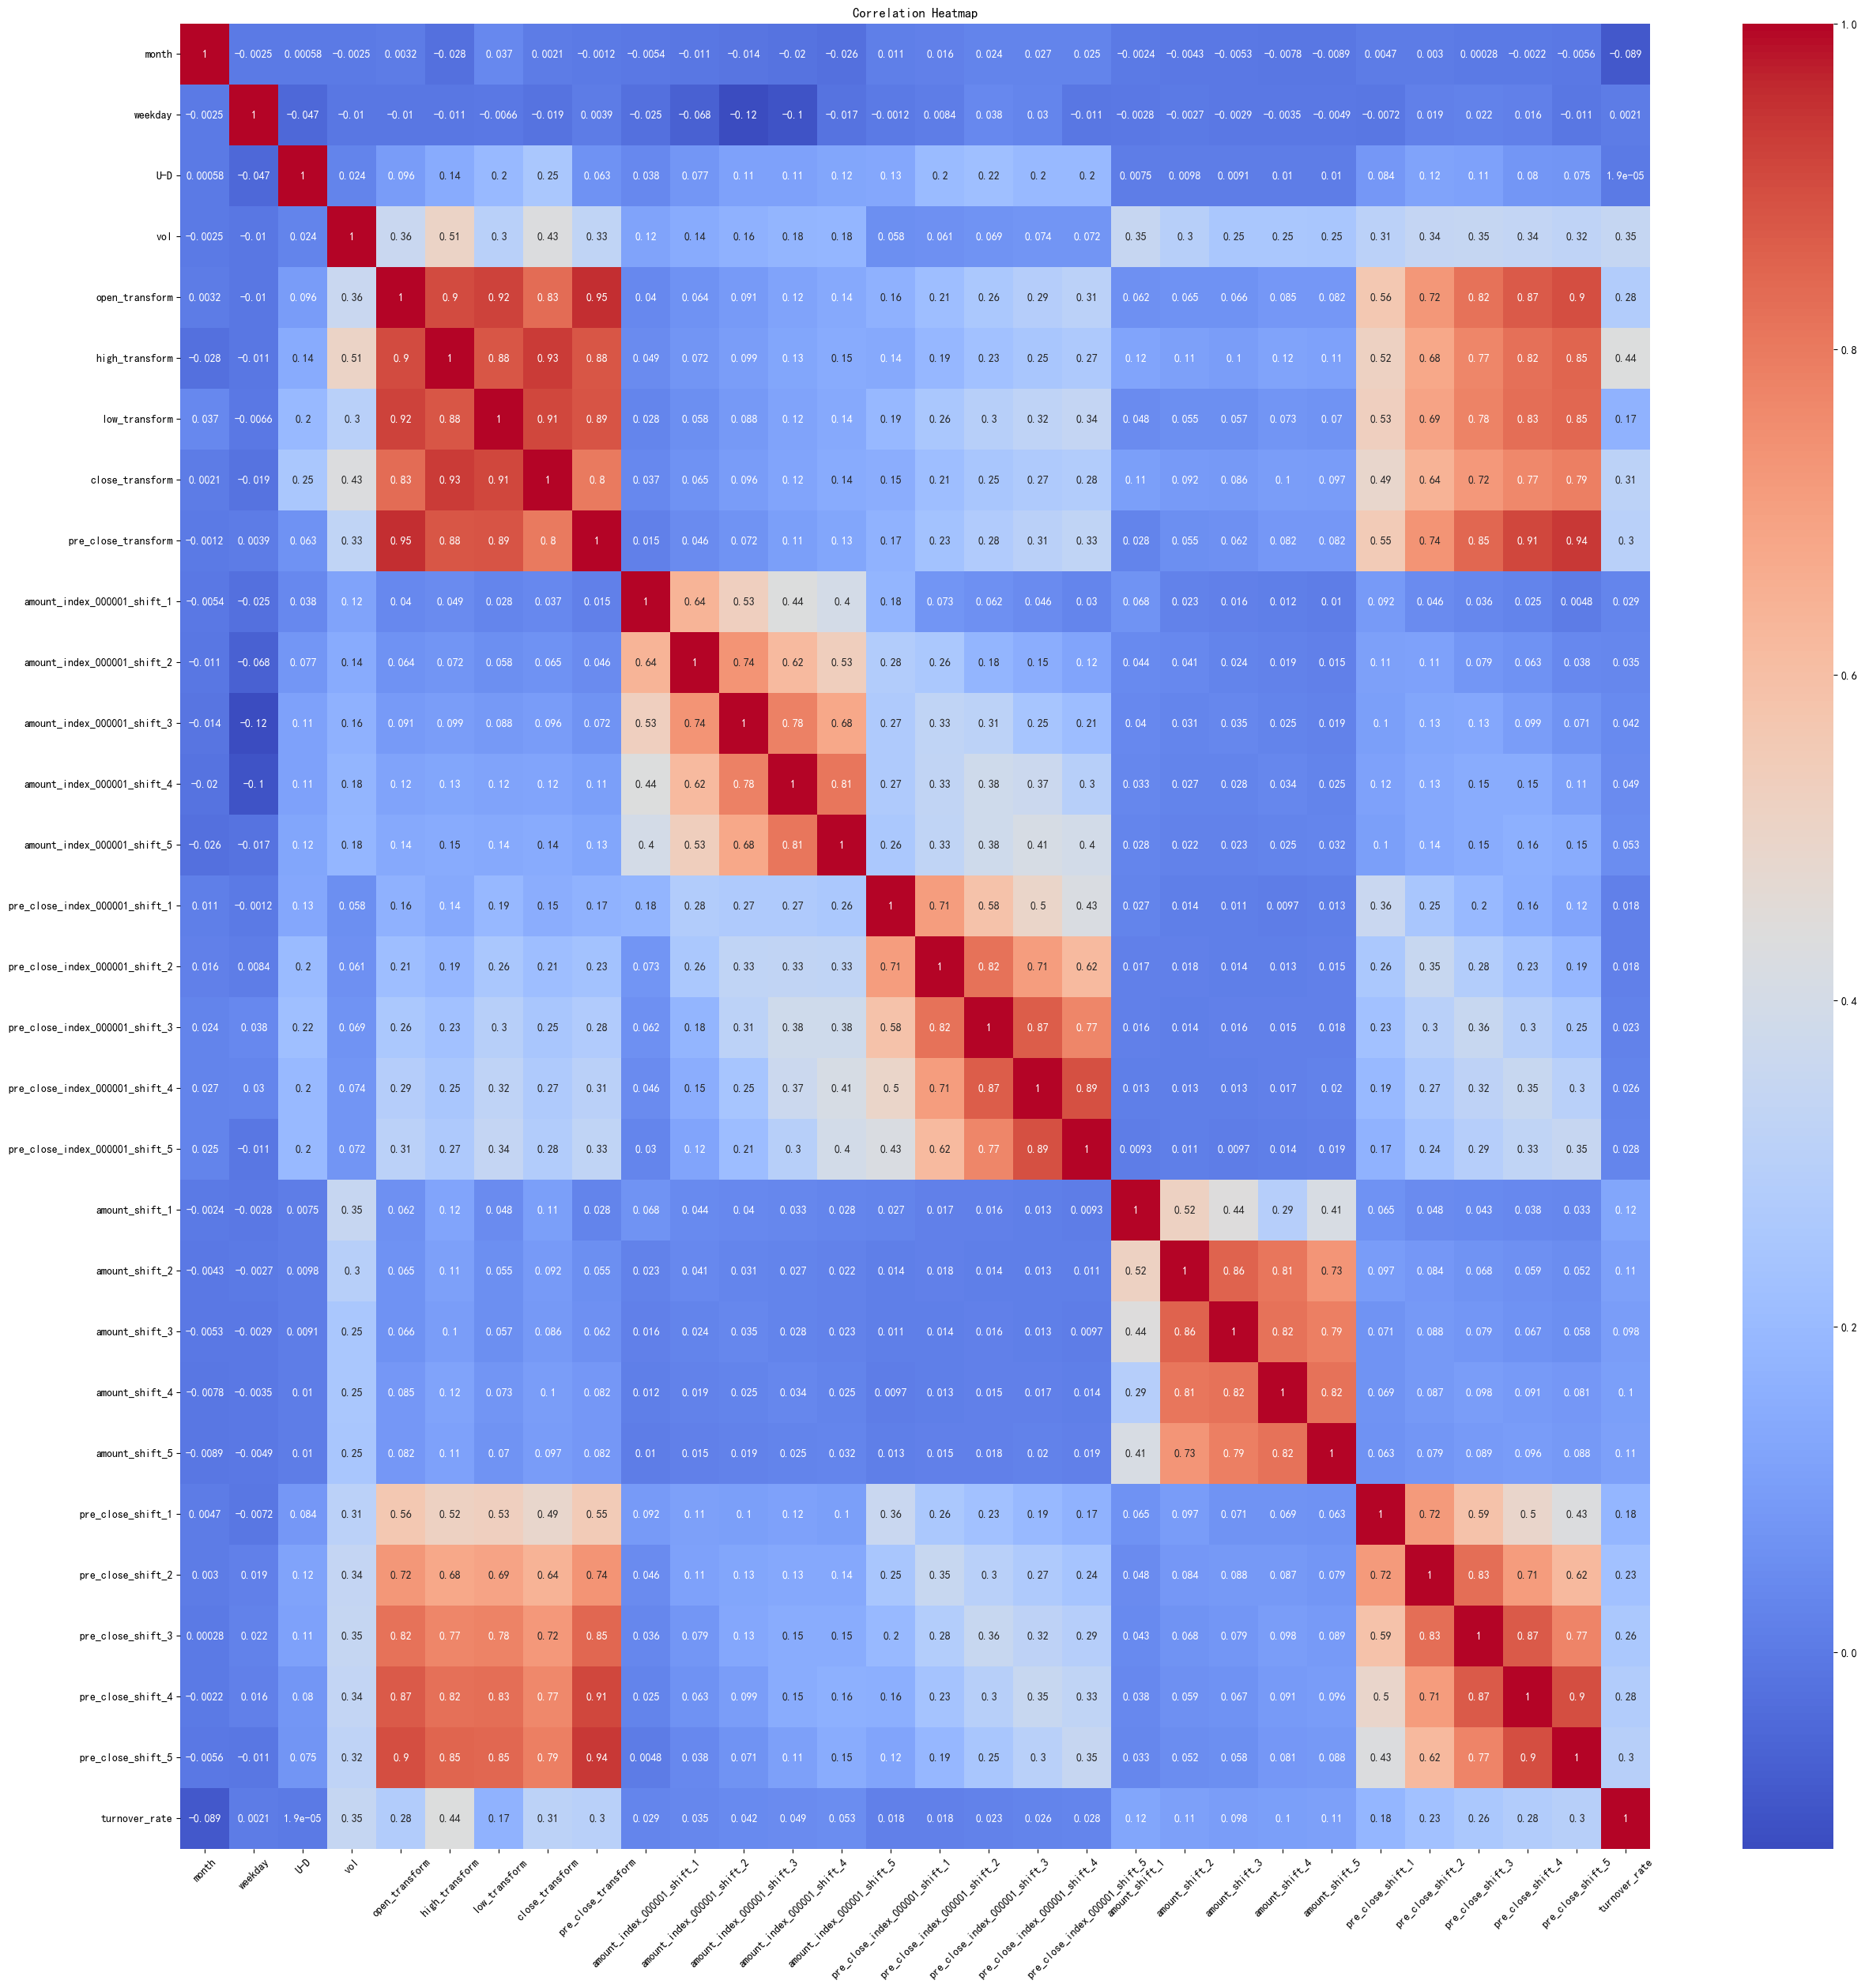

In [220]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
correlation_matrix = stock_info[feature_col].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 模型训练和评价

In [221]:
trn_col = feature_col
# 'high', 'low', 'close', 'pre_close',
trn_col = list(set(trn_col))
label = 'label_final'

trn_date_min = 20200220
trn_date_max = 20230101
# val_date_min = 20230102
# val_date_max = 20230310
test_date_min = 20230102
test_date_max = 20231023

trn_data_idx = (stock_info['trade_date'] >= trn_date_min) & (stock_info['trade_date'] <= trn_date_max) & (stock_info['high']!=stock_info['close'])
# val_data_idx = (stock_info['trade_date'] >= val_date_min) & (stock_info['trade_date'] <= val_date_max)
test_data_idx = (stock_info['trade_date'] >= test_date_min) & (stock_info['trade_date'] <= test_date_max)

trn = stock_info[trn_data_idx][trn_col]
trn_label = stock_info[trn_data_idx][label].values

# val = stock_info[val_data_idx][trn_col]
# val_label = stock_info[val_data_idx][label].values 

test = stock_info[test_data_idx][trn_col]
test_label = stock_info[test_data_idx][label].values

In [222]:
print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
# print('trn data:%d, val data:%d, test data:%d' % (len(trn), len(val), len(test)))
print('trn data:%d, test data:%d' % (len(trn), len(test)))
print('number of features:%d' % len(trn_col))
print(feature_col)

rate of 0: 0.7302, rate of 1: 0.2698
trn data:95258, test data:28899
number of features:30
['month', 'weekday', 'U-D', 'vol', 'open_transform', 'high_transform', 'low_transform', 'close_transform', 'pre_close_transform', 'amount_index_000001_shift_1', 'amount_index_000001_shift_2', 'amount_index_000001_shift_3', 'amount_index_000001_shift_4', 'amount_index_000001_shift_5', 'pre_close_index_000001_shift_1', 'pre_close_index_000001_shift_2', 'pre_close_index_000001_shift_3', 'pre_close_index_000001_shift_4', 'pre_close_index_000001_shift_5', 'amount_shift_1', 'amount_shift_2', 'amount_shift_3', 'amount_shift_4', 'amount_shift_5', 'pre_close_shift_1', 'pre_close_shift_2', 'pre_close_shift_3', 'pre_close_shift_4', 'pre_close_shift_5', 'turnover_rate']


In [223]:
# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV
# # 定义初始参数
# params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'num_leaves': 30,
#     'learning_rate': 0.04
# }

# # 定义参数搜索空间
# param_grid = {
#     'num_leaves': [30, 50, 70, 100],
#     'learning_rate': [0.04, 0.06, 0.08, 0.1]
# }

# # 创建模型
# model = lgb.LGBMClassifier(**params)

# # 使用网格搜索进行参数调优
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3)
# grid_search.fit(trn, trn_label)

# # 输出最佳参数组合和对应的得分
# print("最佳参数组合:", grid_search.best_params_)
# print("最佳得分:", grid_search.best_score_)

In [224]:
# 模型训练及评价
import lightgbm as lgb
import matplotlib.pyplot as plt
import psutil
from sklearn import metrics
def mem_monitor(env):
    if env.iteration % 100 == 0:
        mem = psutil.virtual_memory()
        print("Memory Usage: {:.2f} GB".format(mem.used / 1024 / 1024 / 1024))
param = {'num_leaves': 100,
         'min_data_in_leaf': 20,
         'objective': 'binary',
         'learning_rate': 0.06,
         "boosting": "gbdt",
         "metric": 'binary_logloss',
         "verbosity": -1}
trn_data = lgb.Dataset(trn, trn_label)
# val_data = lgb.Dataset(val, val_label)
num_round =1000
eval_result={}
clf = lgb.train(param, trn_data, num_round, valid_sets=trn_data, callbacks=[lgb.log_evaluation(period=100), lgb.record_evaluation(eval_result), mem_monitor])
# clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=100), lgb.record_evaluation(eval_result), mem_monitor])
# print(clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=1000)
# test_lgb = clf.predict(test, num_iteration=clf.best_iteration)

Memory Usage: 11.69 GB
[100]	training's binary_logloss: 0.454551
Memory Usage: 11.68 GB
[200]	training's binary_logloss: 0.414829
Memory Usage: 11.66 GB
[300]	training's binary_logloss: 0.381377
Memory Usage: 11.66 GB
[400]	training's binary_logloss: 0.352322
Memory Usage: 11.67 GB
[500]	training's binary_logloss: 0.326201
Memory Usage: 11.65 GB
[600]	training's binary_logloss: 0.302341
Memory Usage: 11.65 GB
[700]	training's binary_logloss: 0.280562
Memory Usage: 11.64 GB
[800]	training's binary_logloss: 0.26115
Memory Usage: 11.65 GB
[900]	training's binary_logloss: 0.242917
Memory Usage: 11.64 GB
[1000]	training's binary_logloss: 0.226058


In [225]:
pd.DataFrame({
        'column': trn_col,
        'lgb_importance': clf.feature_importance(),
    }).sort_values(by='lgb_importance', ascending=False)

,column,lgb_importance
14,turnover_rate,5600
15,amount_shift_1,4952
1,amount_shift_5,4640
5,pre_close_shift_1,4593
26,amount_shift_2,4569
19,amount_shift_3,4566
0,amount_shift_4,4564
12,vol,4455
10,pre_close_shift_2,4052
18,pre_close_shift_3,4003


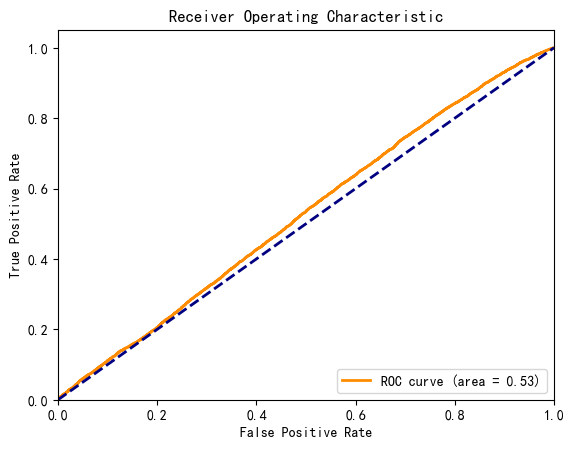

In [226]:
fpr, tpr, thresholds = metrics.roc_curve(test_label, test_lgb)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [227]:
from sklearn.metrics import mean_squared_error, precision_score, f1_score
def evaluation(pred):
    thresh_hold = 0.5
    oof_test_final = pred >= thresh_hold
    print('MSE:', mean_squared_error(test_label, oof_test_final))
    print('Accuracy:',metrics.accuracy_score(test_label, oof_test_final))
    print('Precision:', precision_score(test_label, oof_test_final, average='binary'))
    print('F1_SCORE:', f1_score(test_label, oof_test_final, average='binary'))
    print('confusion_matrix:', metrics.confusion_matrix(test_label, oof_test_final))
    return oof_test_final

In [228]:
def getBuyStock(pred, oof_test_final):
    test_postive_idx = np.argwhere(oof_test_final == 1).reshape(-1)
    test_all_idx = np.argwhere(test_data_idx).reshape(-1)
    # 查看选了哪些股票
    tmp_col = ['ts_code', 'name', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
           'change', 'pct_chg', 'amount', 'is_ST', 'label_final']

    tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_postive_idx]].reset_index()
    tmp_df['label_prob'] = pred[test_postive_idx]
  
    tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

    buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
    buy_df.drop(['index', 'level_0'], axis=1, inplace=True)
    print(len(buy_df), sum(buy_df['label_final']))
    return buy_df

In [229]:
oof_test_final_lgb = evaluation(test_lgb)

MSE: 0.3222256825495692
Accuracy: 0.6777743174504308
Precision: 0.3184593705965242
F1_SCORE: 0.12710911136107986
confusion_matrix: [[18909  1451]
 [ 7861   678]]


In [230]:
buy_df_lgb = getBuyStock(test_lgb, oof_test_final_lgb)

2024 641


In [231]:
from sklearn.ensemble import RandomForestClassifier
# 创建随机森林分类器模型
model = RandomForestClassifier(n_estimators=200, random_state=42)
# 使用训练集拟合模型
model.fit(trn, trn_label)
test_rdf = model.predict(test)

In [232]:
pd.DataFrame({
        'column': trn_col,
        'rdf_importance': model.feature_importances_,
    }).sort_values(by='rdf_importance', ascending=False)

,column,rdf_importance
14,turnover_rate,0.049325
5,pre_close_shift_1,0.045710
15,amount_shift_1,0.044402
10,pre_close_shift_2,0.044389
18,pre_close_shift_3,0.043683
0,amount_shift_4,0.043536
12,vol,0.043465
1,amount_shift_5,0.043380
26,amount_shift_2,0.043350
19,amount_shift_3,0.043310


In [233]:
oof_test_final_rdf = evaluation(test_rdf)

MSE: 0.2980379943942697
Accuracy: 0.7019620056057303
Precision: 0.2716049382716049
F1_SCORE: 0.01011378002528445
confusion_matrix: [[20242   118]
 [ 8495    44]]


In [234]:
buy_df_rdf = getBuyStock(test_rdf, oof_test_final_rdf)

147 39


# 回测

In [235]:
# stock_info.reset_index().head()
# 读取指数信息
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

index_df_SZ = pd.read_csv(os.path.join(base_path,  'OldData', '399001.SZ' + '_NormalData.csv'))
tmp_idx_SZ = (index_df_SZ['trade_date'] >= test_date_min) & (index_df_SZ['trade_date'] <= test_date_max)
index_df_SZ = index_df_SZ.loc[tmp_idx_SZ].reset_index()
index_df_SZ.drop('index', axis=1, inplace=True)

In [236]:
tmp_idx = (index_df['trade_date'] == test_date_min+1)
close1 = index_df[tmp_idx]['close'].values[0]
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

tmp_idx_SZ = (index_df_SZ['trade_date'] == test_date_min+1)
close1_SZ = index_df_SZ[tmp_idx_SZ]['close'].values[0]
tmp_idx_SZ = (index_df_SZ['trade_date'] == test_date_max)
close2_SZ = index_df_SZ[tmp_idx_SZ]['close'].values[0]

In [237]:
from importlib import reload
import Account
reload(Account)
money_init = 100000
account_lgb = Account.Account(money_init, max_hold_period=20, stop_loss_rate=-0.06, stop_profit_rate=0.12)
account_lgb.BackTest(buy_df_lgb, stock_info_copy, index_df, buy_price='open')

20230103  买入 惠程科技 (002168.SZ) 5100股，股价：3.88,花费：19788.0,手续费：5.94，剩余现金：80206.06
20230103  买入 ST国安 (000839.SZ) 7800股，股价：2.54,花费：19812.0,手续费：5.94，剩余现金：60388.12
20230103  买入 川大智胜 (002253.SZ) 1600股，股价：11.77,花费：18832.0,手续费：5.65，剩余现金：41550.47
20230103  买入 国联股份 (603613.SH) 300股，股价：60.8149,花费：18244.47,手续费：5.47，剩余现金：23300.53
20230103  买入 恒生电子 (600570.SH) 400股，股价：40.2323,花费：16092.92,手续费：5，剩余现金：7202.61
20230103  买入 网达软件 (603189.SH) 500股，股价：13.794,花费：6897.0,手续费：5，剩余现金：300.61
20230104  止盈卖出网达软件 (603189.SH) 500股，股价：15.449280000000002,收入：7724.64,手续费：12.72，剩余现金：8012.52，最终盈利：809.92
20230105  买入 云鼎科技 (000409.SZ) 1100股，股价：7.03,花费：7733.0,手续费：5，剩余现金：274.52
20230116  止盈卖出国联股份 (603613.SH) 300股，股价：68.112688,收入：20433.81,手续费：26.56，剩余现金：20681.76，最终盈利：2157.3
20230117  买入 真视通 (002771.SZ) 1700股，股价：11.8724,花费：20183.08,手续费：6.05，剩余现金：492.63
20230118  止盈卖出恒生电子 (600570.SH) 400股，股价：45.060176000000006,收入：18024.07,手续费：23.43，剩余现金：18493.27，最终盈利：1902.72
20230119  止盈卖出川大智胜 (002253.SZ) 1600股，股价：13.182400000000001,收入：21091.84,手续费：

In [238]:
tmp_df2 = buy_df_lgb[['ts_code', 'trade_date', 'label_prob', 'label_final']]
tmp_df2 = tmp_df2.rename(columns={'trade_date':'buy_date'})
tmp_df = account_lgb.info
tmp_df = tmp_df.merge(tmp_df2, on=['ts_code', 'buy_date'], how='left')

In [239]:
tmp_df

,ts_code,name,buy_price,buy_date,buy_num,sell_price,sell_date,profit,label_prob,label_final
0,002168.SZ,惠程科技,3.88,20230103,5100,4.3456,20230201,2339.812272,0.657965,1
1,000839.SZ,ST国安,2.54,20230103,7800,2.57,20230206,201.9966,0.642219,0
2,002253.SZ,川大智胜,11.77,20230103,1600,13.1824,20230119,2226.771008,0.604928,1
3,603613.SH,国联股份,60.8149,20230103,300,68.112688,20230116,2157.299111,0.602726,1
4,600570.SH,恒生电子,40.2323,20230103,400,45.060176,20230118,1902.719108,0.529875,1
...,...,...,...,...,...,...,...,...,...,...
107,002657.SZ,中科金财,16.79,20231019,1600,18.8048,20231027,3176.506816,0.739566,1
108,603220.SH,中贝通信,39.0,20231019,700,34.45,20231020,-3224.5395,0.727197,0
109,600476.SH,湘邮科技,16.4,20231019,300,15.252,20231020,-358.9756,0.609976,0
110,600410.SH,华胜天成,7.16,20231020,800,8.0192,20231023,670.94464,0.579525,1


In [240]:
account_rdf = Account.Account(money_init, max_hold_period=20, stop_loss_rate=-0.06, stop_profit_rate=0.12)
account_rdf.BackTest(buy_df_rdf, stock_info_copy, index_df, buy_price='open')

20230103  买入 ST国安 (000839.SZ) 7800股，股价：2.54,花费：19812.0,手续费：5.94，剩余现金：80182.06
20230103  买入 超讯通信 (603322.SH) 1200股，股价：16.32,花费：19584.0,手续费：5.88，剩余现金：60592.18
20230105  买入 中贝通信 (603220.SH) 1800股，股价：11.2277,花费：20209.86,手续费：6.06，剩余现金：40376.26
20230206  止盈卖出中贝通信 (603220.SH) 1800股，股价：12.575024,收入：22635.04,手续费：29.43，剩余现金：62981.88，最终盈利：2389.69
20230206  到期卖出超讯通信 (603322.SH) 1200股，股价：16.85,收入：20220.0,手续费：26.29，剩余现金：83175.59，最终盈利：603.84
20230206  到期卖出ST国安 (000839.SZ) 7800股，股价：2.57,收入：20046.0,手续费：26.06，剩余现金：103195.53，最终盈利：202.0
20230213  买入 天娱数科 (002354.SZ) 3100股，股价：6.48,花费：20088.0,手续费：6.03，剩余现金：83101.5
20230216  止盈卖出天娱数科 (002354.SZ) 3100股，股价：7.257600000000001,收入：22498.56,手续费：29.25，剩余现金：105570.82，最终盈利：2375.29
20230302  买入 广电网络 (600831.SH) 3200股，股价：6.4474,花费：20631.68,手续费：6.19，剩余现金：84932.95
20230329  到期卖出广电网络 (600831.SH) 3200股，股价：6.6766,收入：21365.12,手续费：27.77，剩余现金：106270.29，最终盈利：699.48
20230404  买入 世纪华通 (002602.SZ) 3200股，股价：6.5,花费：20800.0,手续费：6.24，剩余现金：85464.05
20230404  买入 金桥信息 (603918.SH) 1200股，股价

In [241]:
tmp_df2 = buy_df_rdf[['ts_code', 'trade_date', 'label_prob', 'label_final']]
tmp_df2 = tmp_df2.rename(columns={'trade_date':'buy_date'})
tmp_df = account_rdf.info
tmp_df = tmp_df.merge(tmp_df2, on=['ts_code', 'buy_date'], how='left')

In [242]:
tmp_df

,ts_code,name,buy_price,buy_date,buy_num,sell_price,sell_date,profit,label_prob,label_final
0,000839.SZ,ST国安,2.54,20230103,7800.0,2.57,20230206,201.9966,1,0
1,603322.SH,超讯通信,16.32,20230103,1200.0,16.85,20230206,603.8388,1,0
2,603220.SH,中贝通信,11.2277,20230105,1800.0,12.575024,20230206,2389.694686,1,1
3,002354.SZ,天娱数科,6.48,20230213,3100.0,7.2576,20230216,2375.285472,1,1
4,600831.SH,广电网络,6.4474,20230302,3200.0,6.6766,20230329,699.47584,1,0
5,002602.SZ,世纪华通,6.5,20230404,3200.0,6.045,20230406,-1487.3872,1,0
6,603918.SH,金桥信息,16.4784,20230404,1200.0,15.324912,20230407,-1414.024687,1,0
7,000997.SZ,新大陆,17.74,20230510,1100.0,16.4982,20230524,-1395.426626,1,0
8,002131.SZ,利欧股份,2.41,20230510,8500.0,2.2413,20230522,-1464.861865,1,0
9,002238.SZ,天威视讯,7.807,20230510,2600.0,7.26051,20230517,-1451.503984,1,0


In [243]:
def accountPerformance(account):
    account_profit = (account.market_value - money_init) / money_init
    index_profit = (close2 - close1) / close1
    index_profit_SZ = (close2_SZ - close1_SZ ) / close1_SZ
    win_rate = account.victory / (account.victory + account.defeat)
    print('账户盈利情况:%.4f' % account_profit)
    print('上证指数浮动情况:%.4f' % index_profit)
    print('深证成指浮动情况:%.4f' % index_profit_SZ)
    print('交易胜率:%.4f' % win_rate)
    print('最大回撤率:%.4f' % account.max_retracement)

In [244]:
print('--------lgbm---------')
accountPerformance(account_lgb)
print('--------rdf---------')
accountPerformance(account_rdf)

--------lgbm---------
账户盈利情况:0.4070
上证指数浮动情况:-0.0305
深证成指浮动情况:-0.1070
交易胜率:0.4732
最大回撤率:0.1052
--------rdf---------
账户盈利情况:-0.0187
上证指数浮动情况:-0.0305
深证成指浮动情况:-0.1070
交易胜率:0.4091
最大回撤率:0.1381


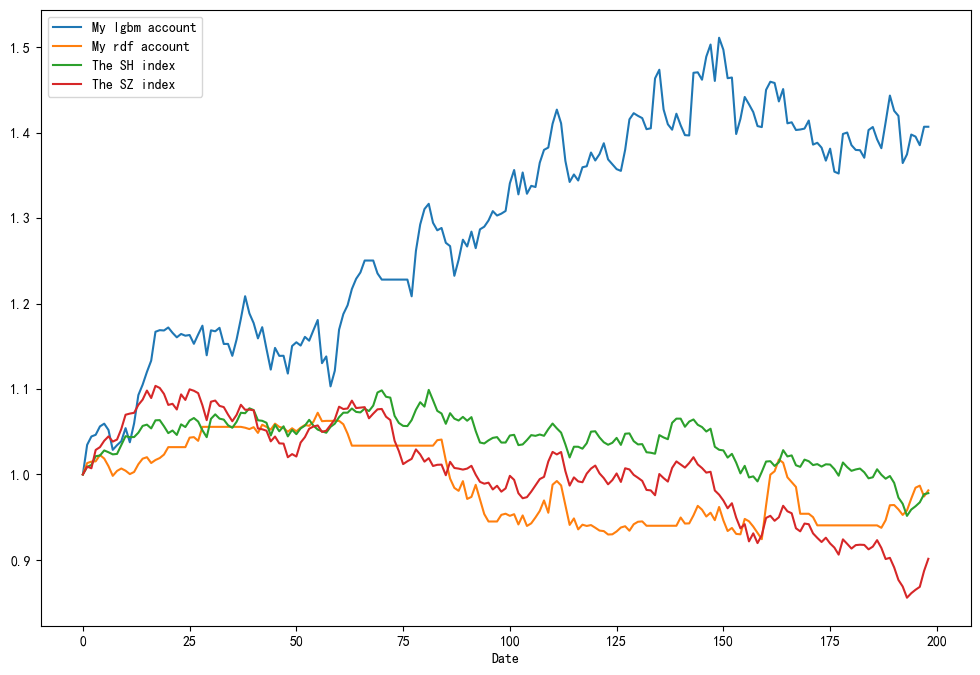

In [245]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min+1]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
index_value_SZ = list(index_df_SZ[index_df_SZ['trade_date']==test_date_min+1]['pre_close']) + list(index_df_SZ.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(account_lgb.market_value_all, account_rdf.market_value_all, index_value, index_value_SZ)

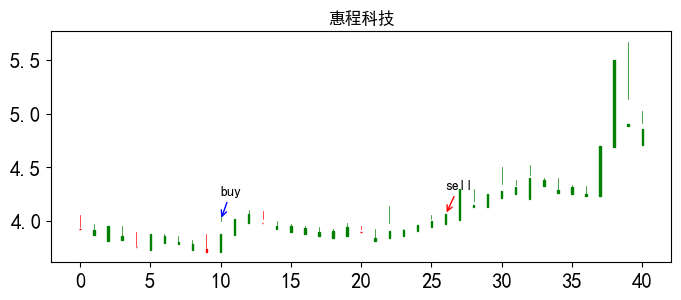

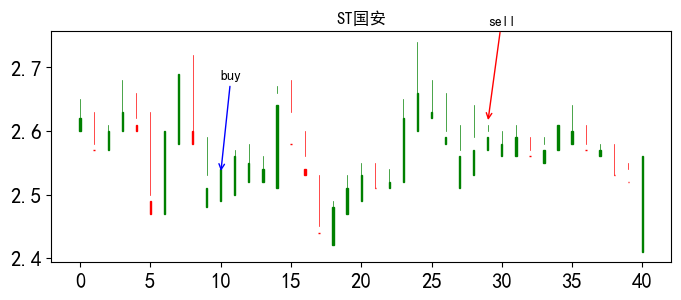

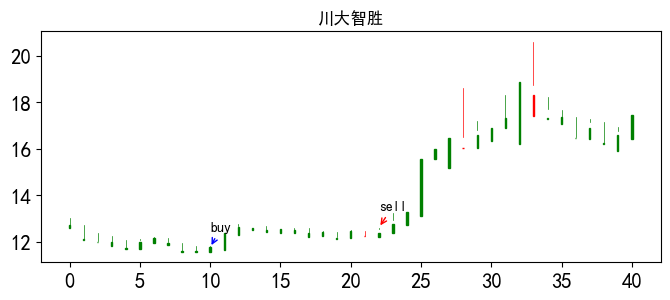

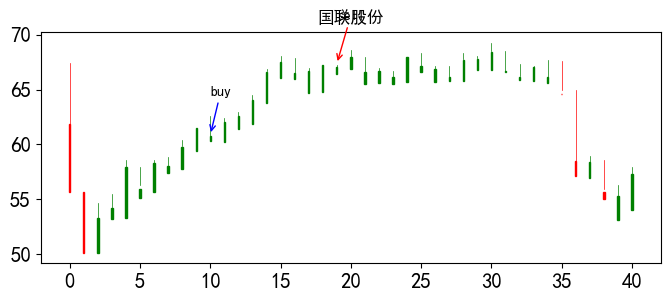

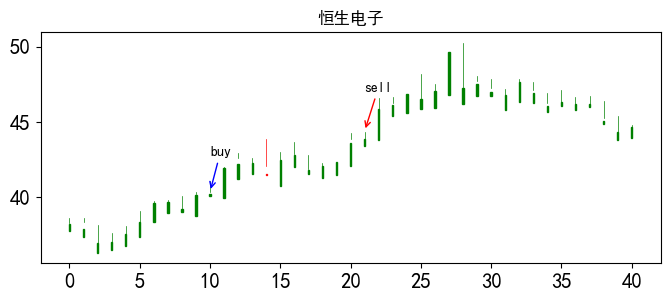

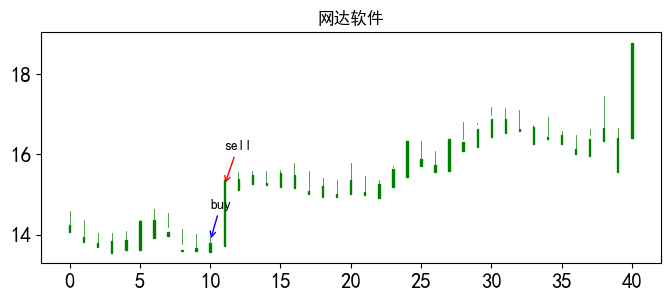

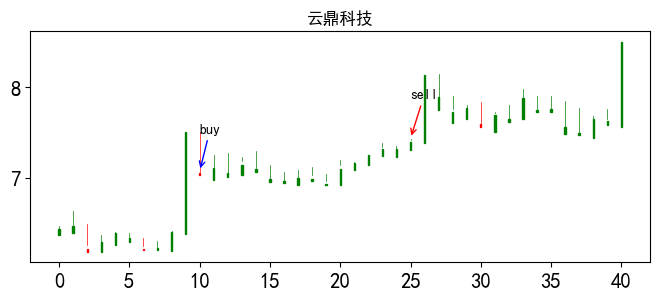

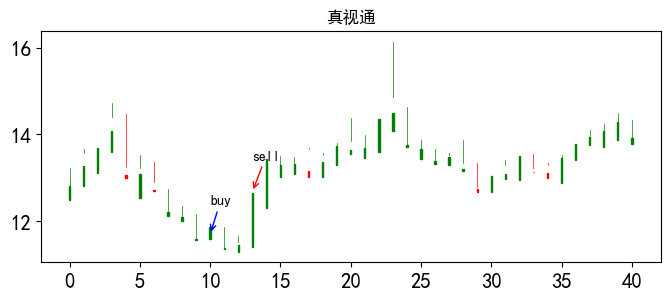

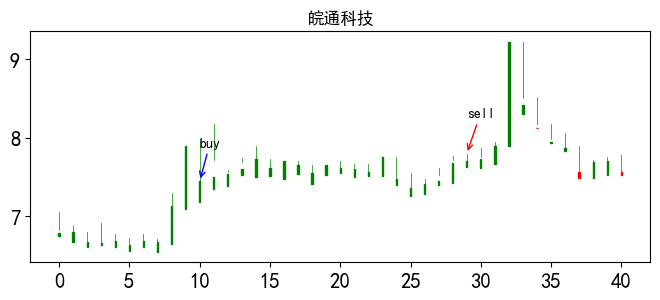

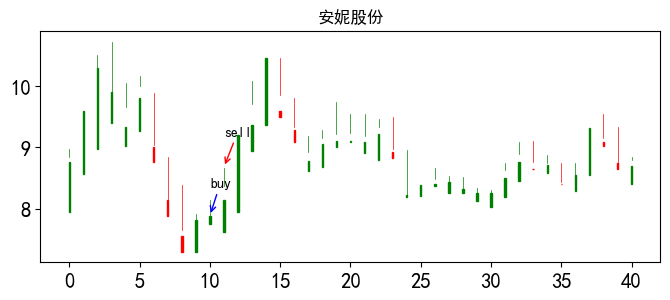

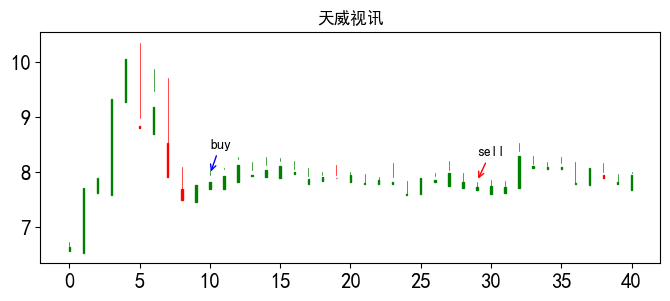

In [246]:
num = 0
for ts_code, buy_date, sell_date in zip(account_lgb.info['ts_code'], account_lgb.info['buy_date'], account_lgb.info['sell_date']):
    Draw.Draw_Stock(ts_code, stock_info, buy_date, sell_date, left_offset=10, right_offset=30)
    num = num + 1
    if num > 10:
         break

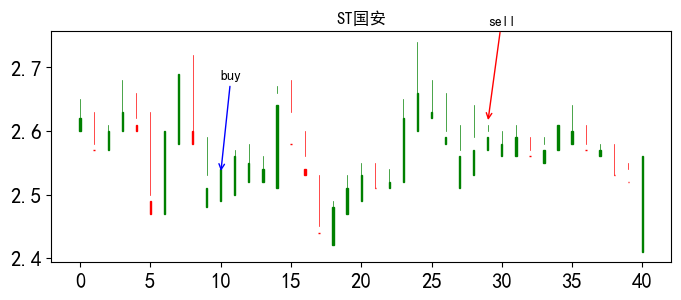

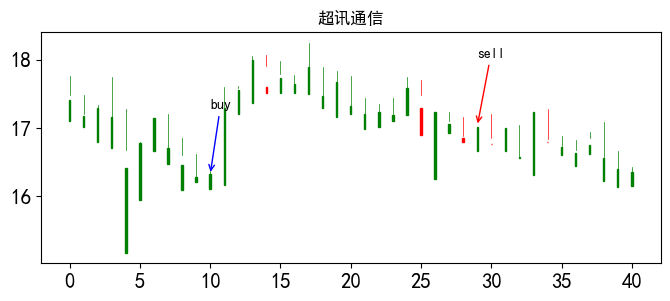

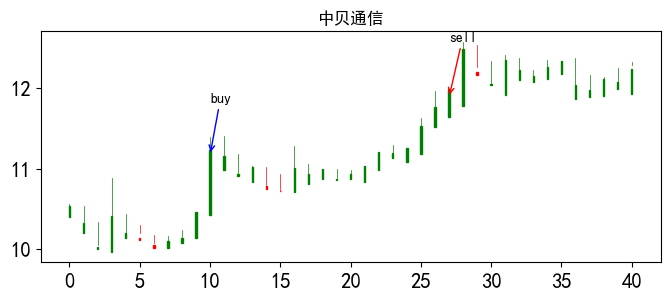

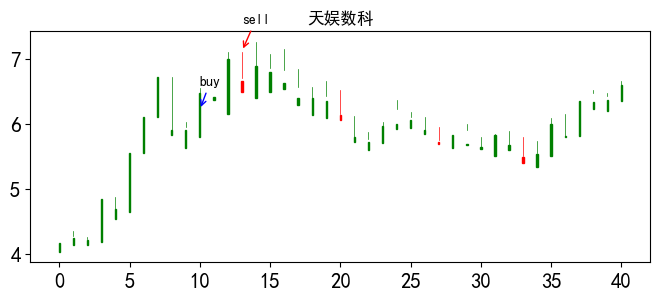

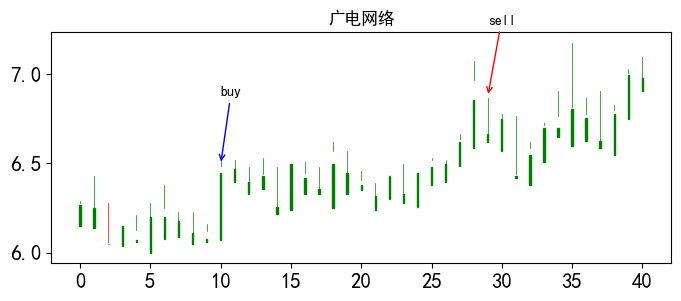

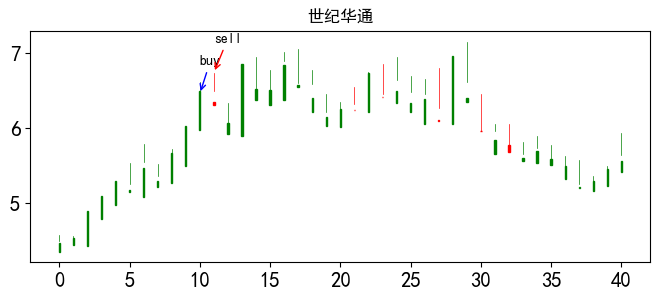

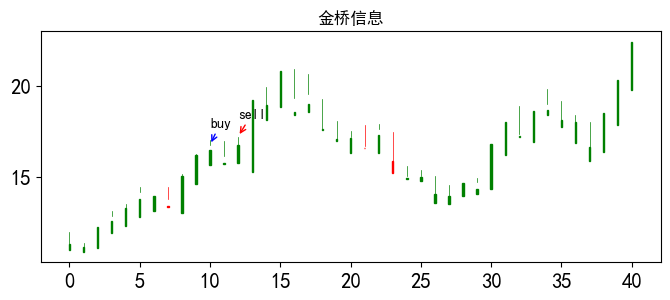

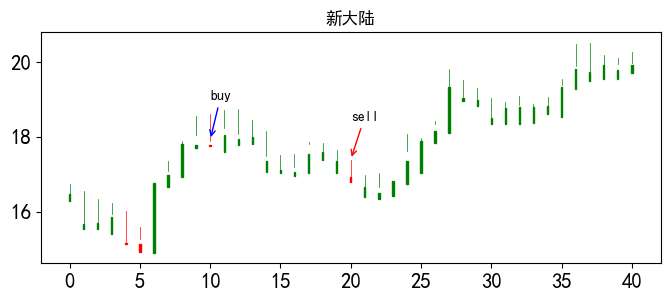

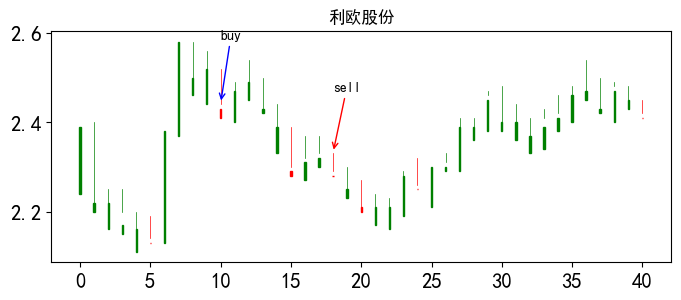

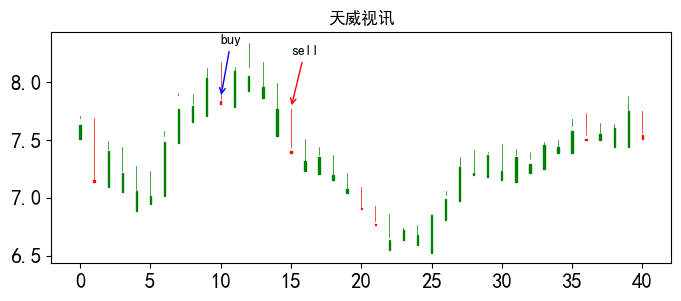

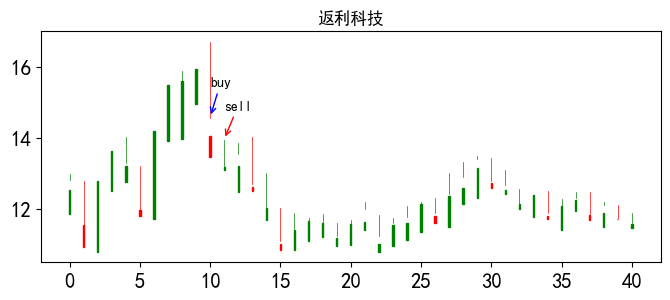

In [247]:
num = 0
for ts_code, buy_date, sell_date in zip(account_rdf.info['ts_code'], account_rdf.info['buy_date'], account_rdf.info['sell_date']):
    Draw.Draw_Stock(ts_code, stock_info, buy_date, sell_date, left_offset=10, right_offset=30)
    num = num + 1
    if num > 10:
         break